# Relax Inc. Take-Home Challenge

## Import and Load Data

The data has the following two tables
- A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years.
- A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


In [2]:
# Load the data
user_engagement = pd.read_csv('takehome_user_engagement.csv',parse_dates=['time_stamp'])
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [3]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


## Adopted User


- To define an "adopted user," they must have logged into the product on at least three separate days within a single seven-day period. 

- The pandas library offers a rolling function that creates a window based on actual observations, excluding any missing dates from the calculations. Therefore, this window can potentially span more than seven calendar days in a seven-day period. To include missing dates, resample the time series to a daily frequency, use the fillna method to fill in any missing values, and then calculate the rolling window.

In [5]:
# Use date instead of time_stamp to count the daily visits
user_engagement['date'] = user_engagement['time_stamp'].dt.date

# Group by user_id and date and calculate the number of visits per day
daily_visited = user_engagement.groupby(['user_id', 'date']).size().reset_index(name='visited')

# Convert the 'date' column to datetime 
daily_visited['date'] = pd.to_datetime(daily_visited['date'])

In [6]:
# resample the time series to a daily frequency

# Get the minimum and maximum date in the dataset
min_date = daily_visited['date'].min()
max_date = daily_visited['date'].max()

# Create a range of dates from the minimum to the maximum date
date = pd.date_range(start=min_date, end=max_date, freq='1D')

# Create a new DataFrame with the range of dates
df_date = pd.DataFrame(date, columns=['date'])

# Get the unique user_ids from the daily_visited DataFrame
user_id = daily_visited['user_id'].unique()

# Create a multi-index with all combinations of user_id and date in the date range
index = pd.MultiIndex.from_product([user_id, df_date['date']], names=['user_id', 'date'])

# Create a new DataFrame with the multi-index and reset the index to have user_id and date as columns
df_full = pd.DataFrame(index=index).reset_index()

# Merge the new DataFrame with the daily_visited DataFrame 
# to get the number of visits per day for each user-date combination
df_full = df_full.merge(daily_visited, on=['user_id', 'date'], how='left')

# Fill NaN values in the 'visited' column with 0 
df_full = df_full.fillna(0)

In [7]:
# define adopted_users

df_full = df_full.set_index('date')
daily_visited.set_index('date', inplace=True)

# Calculate the rolling 7-day sum of visits for each user
rolling_7 = df_full.groupby('user_id')['visited'].rolling('7D').sum().reset_index()

# adopted users as those who have 3 or more logins in any 7-day period
adopted_users = rolling_7[rolling_7['visited'] >= 3]['user_id'].unique()

In [8]:
print(f'The total number of adopted users: {len(adopted_users)}')

The total number of adopted users: 1602


In [9]:
# Add 'adopted_user' column to the 'users' DataFrame. 
# 1 if the user is adopted users and 0 otherwise.
users['adopted_user'] = users['object_id'].isin(adopted_users).astype(int)


## Feature Engineering

### Identify Missing Values

In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


The columns `last_session_creation_time` and `invited_by_user_id` contain a high number of missing values.

- `last_session_creation_time` : It is possible that the data is NaN because the user did not log in during the data collection period. To confirm this, check the total number of visits.
- `invited_by_user_id`: It is available only if applicable. 

#### last_session_creation_time

In [11]:
# calculate the total number of visits per user
num_visits = daily_visited.groupby('user_id')['visited'].sum().reset_index()

# Merge dataframe and fill NaN values in the 'visited' column with 0
user_df = users.merge(num_visits, left_on='object_id', right_on='user_id', how='left')
user_df['visited'] = user_df['visited'].fillna(0)
user_df = user_df.rename(columns={'visited':'total_visits'})

In [12]:
no_login = user_df[user_df['total_visits']==0]
print(f'The total number of users who have not logged in even once: {len(no_login)}')

The total number of users who have not logged in even once: 3177


In [13]:
# check the rows where the 'last_session_creation_time' is NaN, and the 'visited' column is zero.
con1 = user_df[user_df['last_session_creation_time'].isna() & (user_df['total_visits'] != 0)]
con2 = user_df[user_df['last_session_creation_time'].notna() & (user_df['total_visits'] == 0)]

len(con1), len(con2)

(0, 0)

Therefore, I conclude that if the user has not logged in even once, the `last_session_creation_time` is NaN and account creation time is not counted as a visit. 

The `last_session_creation_time` is given in Unix timestamp format, which represents the number of seconds since the Unix epoch. Before handling missing values, convert this format into a date format. Then, create a new column,`usage_duration`, to represent the duration of usage by subtracting the `creation_time` from the `last_session_date`.  If `last_session_creation_time` is NaN, it means that there were no logins after creation, which implies that the `usage_duration` is equal to 0. In such cases, fill the NaN values with 0.

In [14]:
user_df['last_session_date'] = pd.to_datetime(user_df['last_session_creation_time'], unit='s')

# Create a new column representing the actual usage duration 
# by subtracting creation_time from last_session_creation_time
user_df['creation_time'] =  pd.to_datetime(user_df['creation_time'])
user_df['usage_duration'] = (user_df['last_session_date'] - user_df['creation_time']).dt.days


user_df['usage_duration'] = user_df['usage_duration'].fillna(0)

#### invited_by_user_id

In [15]:
# Replace NaN values in the invited_by_user_id column with 0.
user_df['invited_by_user_id'] = user_df['invited_by_user_id'].fillna(0)

In [16]:
# Create IsInvited column 
user_df['IsInvited'] = (user_df['invited_by_user_id'] != 0).astype(int)

In [17]:
# Create a new column to count the number of times a user has invited others
invites_count = user_df['invited_by_user_id'].value_counts()
user_df['invite_count'] = user_df['object_id'].map(invites_count)

# Fill NaN values in the invite_count column with 0 (indicating that the user hasn't invited anyone)
user_df['invite_count'].fillna(0, inplace=True)

### Encoding Categorical Features

In [18]:
# one-hot encoding for the 'creation_source' 
one_hot_encoded = pd.get_dummies(user_df['creation_source'],dtype=int)

In [19]:
user_df = pd.concat([user_df, one_hot_encoded], axis=1)

# EDA

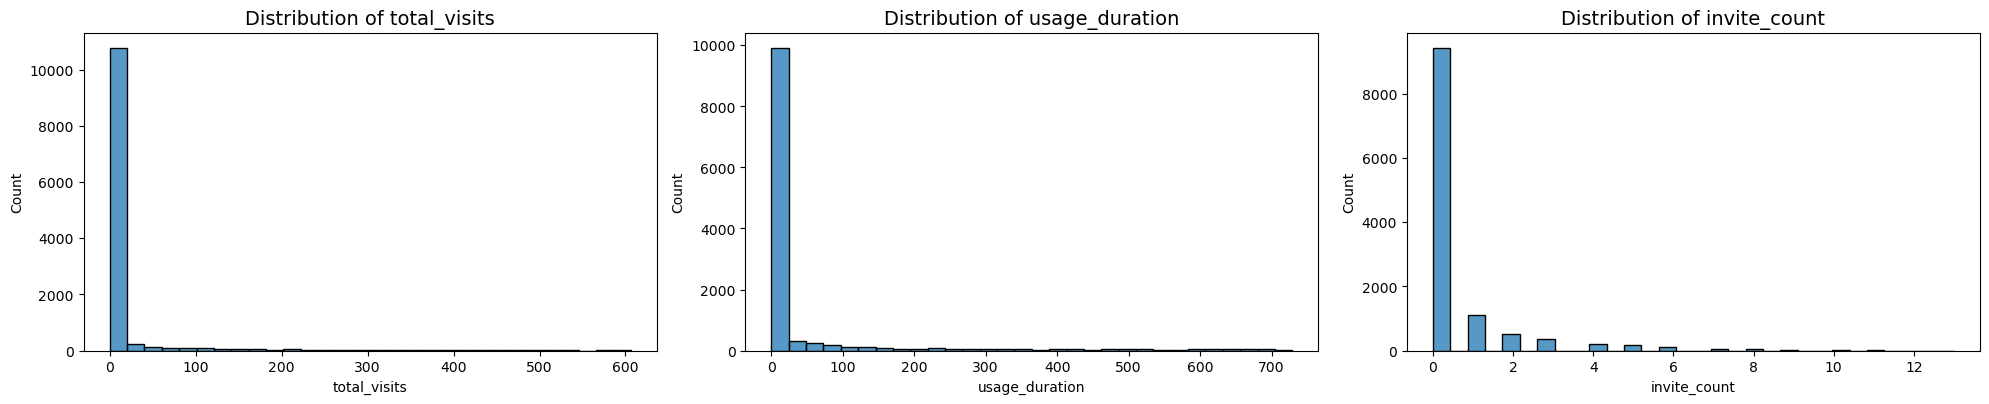

In [25]:
continuous_columns = ['total_visits', 'usage_duration', 'invite_count']


plt.figure(figsize=(20, 15))

# Plot histograms for continuous variables
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(user_df[column], bins=30)
    plt.title(f'Distribution of {column}', fontsize=14)

    
plt.tight_layout()
plt.show()


All three distributions exhibit a right-skewed pattern. This implies that the majority of users tend to have a short usage duration and visit the platform only a few times. This suggests that a considerable proportion of users are not actively engaging with the platform.

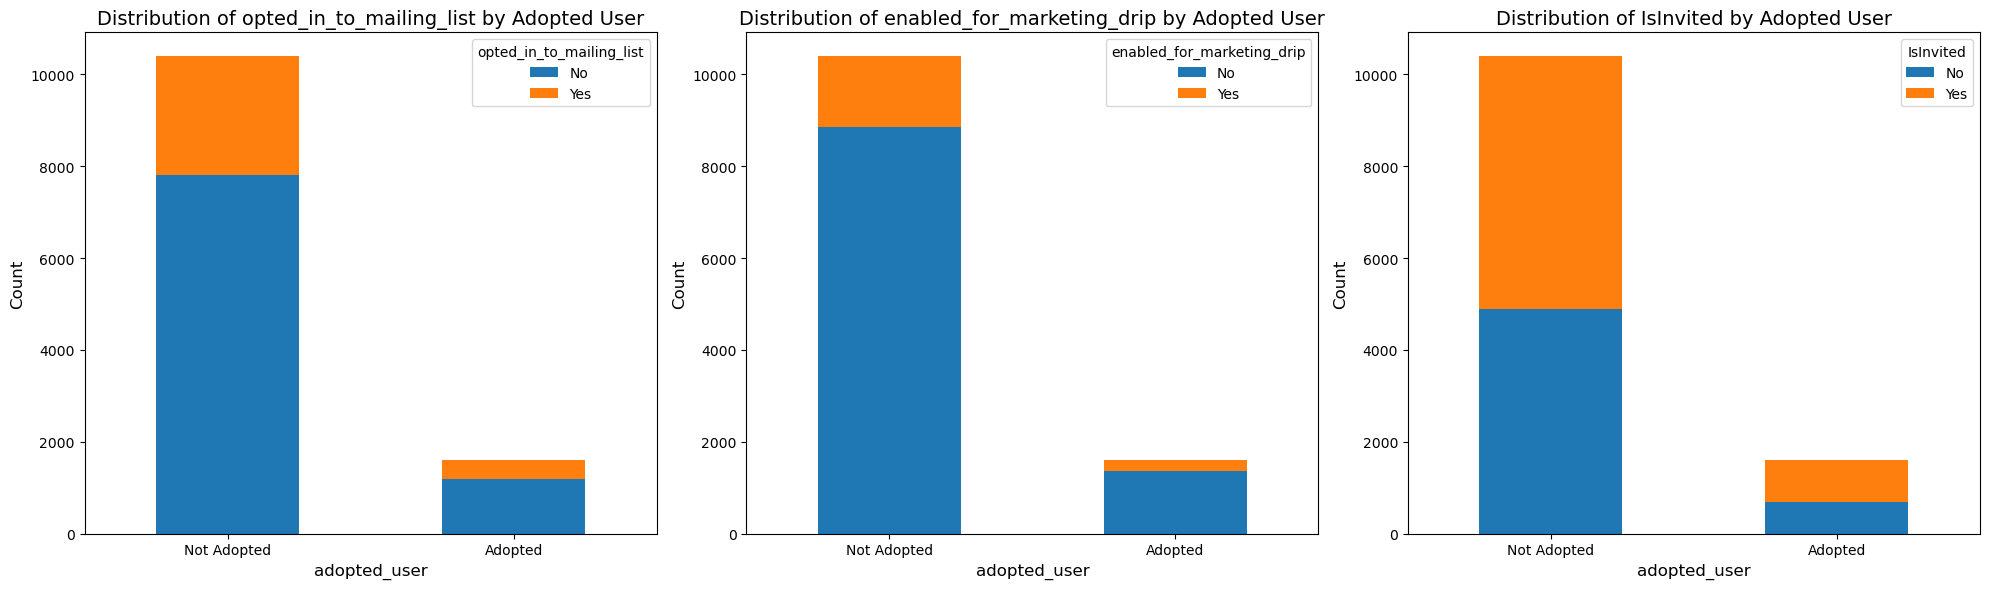

In [21]:
categorical_columns = [
    'opted_in_to_mailing_list', 
    'enabled_for_marketing_drip', 
    'IsInvited'
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Create stacked bar plots for each categorical column
for i, column in enumerate(categorical_columns):
    ax = axes[i]
    
    grouped_data = user_df.groupby([column, 'adopted_user']).size().reset_index(name='count')
    
    pivot_data = grouped_data.pivot_table(values='count', index=column, columns='adopted_user').reset_index()
    
    pivot_data.set_index(column).T.plot(kind='bar', stacked=True, ax=ax)   

    ax.set_title(f'Distribution of {column} by Adopted User', fontsize=14)
    ax.set_xlabel('adopted_user', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticklabels(['Not Adopted', 'Adopted'], rotation=0)
    ax.legend(title=column, labels=['No', 'Yes'])


plt.tight_layout()
plt.show()


Based on the plots, it appears that there are only minor differences in the proportions of adopted and non-adopted users across various categories. Opting into the mailing list and being part of the marketing drip does not seem to have a significant impact on the proportion of users who become adopted. However, those who were invited to the platform are slightly more likely to become adopted users compared to those who were not invited. This implies that these features may not be strong predictors of user adoption.


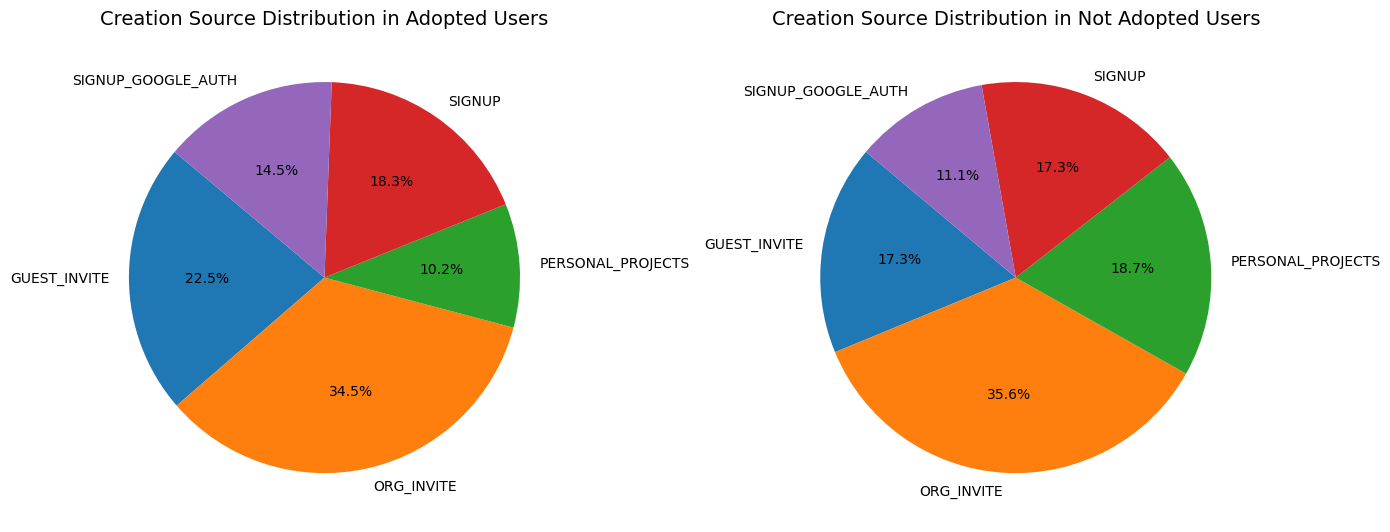

In [22]:
# Group the data by 'adopted_user' and 'creation_source' and calculate the count for each group
creation_source_grouped = user_df.groupby(['adopted_user', 'creation_source']).size().reset_index(name='count')
adopted_users_data = creation_source_grouped[creation_source_grouped['adopted_user'] == 1]
not_adopted_users_data = creation_source_grouped[creation_source_grouped['adopted_user'] == 0]


# Create the pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(adopted_users_data['count'], labels=adopted_users_data['creation_source'], autopct='%1.1f%%', startangle=140)
axes[0].set_title('Creation Source Distribution in Adopted Users', fontsize=14)


axes[1].pie(not_adopted_users_data['count'], labels=not_adopted_users_data['creation_source'], autopct='%1.1f%%', startangle=140)
axes[1].set_title('Creation Source Distribution in Not Adopted Users', fontsize=14)


plt.tight_layout()
plt.show()


Organizational and guest invites are the most popular channels for user acquisition for both adopted and non-adopted users. Although the two distributions are similar, there are slight differences in the proportions. It is worth noting that a significant number of non-adopted users come from personal projects, which constitutes a slightly larger proportion compared to adopted users.

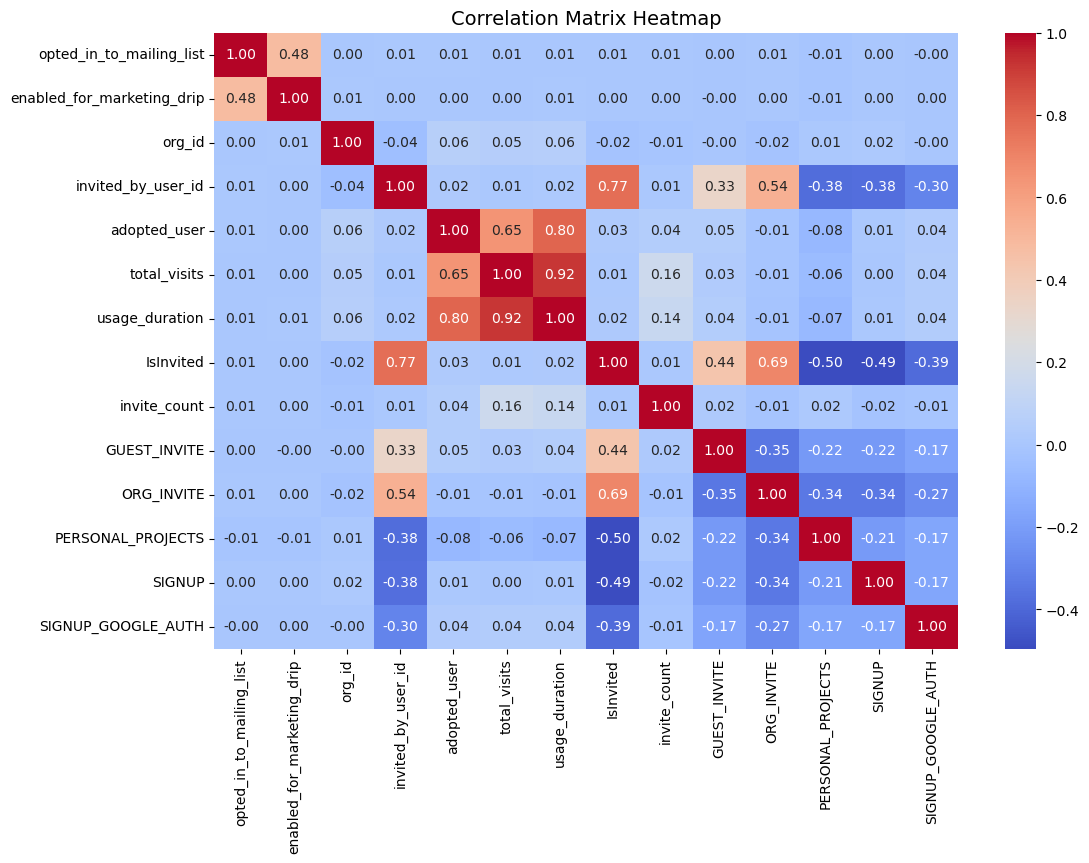

In [24]:
# Calculate the correlation matrix
df = user_df.drop(columns=['object_id','creation_time','name','email','creation_source',
                           'last_session_creation_time', 'user_id' ,'last_session_date' ])
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix Heatmap', fontsize=14)
plt.show()

Here are a few observations from the heatmap

- Adopted users and usage duration: There is a high positive correlation (0.79) between adopted users and usage duration. This suggests that users who have adopted the product tend to use it for longer periods of time.

- Total visits and usage duration: There is a strong positive correlation (0.61) between total visits and usage duration. This indicates that users who visit the product more often tend to use it for longer periods of time.

- Opted-in to mailing list and enabled for marketing drip: There is a mild positive correlation (0.48) between users who opted-in to the mailing list and users who are enabled for the marketing drip. This suggests that users who are interested in one are somewhat more likely to be interested in the other as well.

- Invite count and IsInvited: There is a moderate positive correlation (0.53) between invite count and IsInvited. This implies that users who were invited tend to invite more users themselves.


# Identify Which Factors Predict Future User Adoption

## Feature Selection and Train/Test Split

In [26]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted_user                12000 non-null  int64         
 11  user_id                     8823 non-null   float64   

In [28]:
# Feature Selection 

features = ['opted_in_to_mailing_list', 
            'enabled_for_marketing_drip', 
            'org_id',
            'total_visits', 
            'usage_duration',
            'IsInvited',
            'invite_count', 
            'GUEST_INVITE',
            'ORG_INVITE', 
            'PERSONAL_PROJECTS',
            'SIGNUP',
            'SIGNUP_GOOGLE_AUTH'
             ]

target = 'adopted_user'

In [29]:
# Splitting the data into training and testing sets

X = user_df[features]
y = user_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Logistic Regression Model

In [36]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2074
           1       0.98      0.93      0.95       326

    accuracy                           0.99      2400
   macro avg       0.98      0.96      0.97      2400
weighted avg       0.99      0.99      0.99      2400



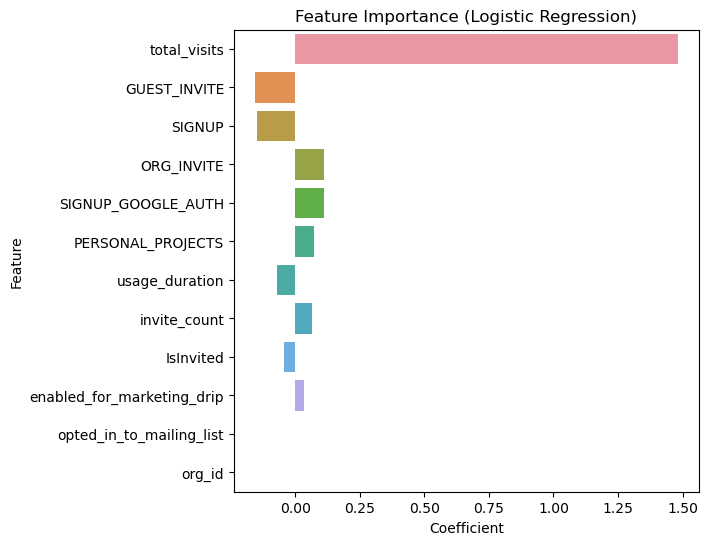

In [44]:
# Get the coefficients of the features from the logistic regression model
feature_coefficients = logreg.coef_[0]

# Create a dataframe to hold the features and their respective coefficients
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': feature_coefficients})

feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(6, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()


In [42]:
feature_importance_df

,Feature,Coefficient,Abs_Coefficient
3,total_visits,1.481251,1.481251
7,GUEST_INVITE,-0.155613,0.155613
10,SIGNUP,-0.149520,0.149520
8,ORG_INVITE,0.112632,0.112632
11,SIGNUP_GOOGLE_AUTH,0.109994,0.109994
9,PERSONAL_PROJECTS,0.073432,0.073432
4,usage_duration,-0.072437,0.072437
6,invite_count,0.066833,0.066833
5,IsInvited,-0.042980,0.042980
1,enabled_for_marketing_drip,0.034915,0.034915


The logistic regression model coefficients represent the log-odds of a user being adopted based on the features. Based on the coefficients, here's an analysis of feature importance:
- total_visits: The most significant feature with a positive coefficient of approximately 1.48, indicating that the higher the total number of visits, the higher the probability of being an adopted user.
- GUEST_INVITE and SIGNUP: These features have negative coefficients (-0.155 and -0.147 respectively), suggesting that users who signed up via guest invites or direct signups are slightly less likely to be adopted compared to the reference category.
- ORG_INVITE and SIGNUP_GOOGLE_AUTH: These features have positive coefficients (0.113 and 0.108 respectively), indicating that users who signed up via organizational invites or Google authentication are slightly more likely to be adopted compared to the reference category.
- PERSONAL_PROJECTS: This feature also has a positive coefficient (0.076), suggesting that users who signed up for personal projects have a slightly higher likelihood of being adopted users compared to the reference category.
- usage_duration: This feature has a negative coefficient (-0.072), which is somewhat counterintuitive because we would expect a longer usage duration to be associated with a higher likelihood of adoption. This may be due to the interaction with other features.
- invite_count, IsInvited, enabled_for_marketing_drip, and org_id: These features have smaller coefficients, indicating a lesser influence on the likelihood of user adoption.
- opted_in_to_mailing_list: This feature has a very small negative coefficient, suggesting a minimal influence on the likelihood of adoption.

In conclusion, the total_visits feature is a significant predictor of user adoption in the logistic regression model. However, the model also emphasizes the impact of the creation source features (like GUEST_INVITE, SIGNUP, etc.) on user adoption.